# [Matlab code](https://www.di.ens.fr/~cappe/Code/OnlineEM/)

In [15]:
%matplotlib inline

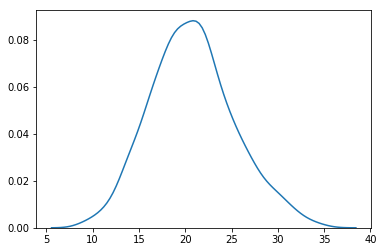

In [2]:
import numpy as np
import seaborn as sns

def simulate_poisson_mixture(rates, n, seed=None):
    np.random.seed(seed)
    for _ in range(n):
        yield sum(np.random.poisson(lam=rate) for rate in rates)
        
counts = list(simulate_poisson_mixture(rates=[2, 19], n=1000, seed=42))

sns.kdeplot(counts);

In [ ]:
http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.88.334&rep=rep1&type=pdf

## Batch

In [32]:
weights * rates

array([0., 0., 0., 0.])

## Titterington

Based on [*Recursive Parameter Estimation Using Incomplete Data*](https://apps.dtic.mil/dtic/tr/fulltext/u2/a116190.pdf).

In [10]:
import numpy as np
from scipy import special

n = 2

weights = np.ones(n) / n
rates = np.random.uniform(size=n)

for i, count in enumerate(counts):
    
    gamma = 1 / (i + 1)  # The step size
    dnorm = np.log(special.gamma(count + 1))
    
    # 1: Compute a posteriori probabilities and likelihood
    
    # Compute all densities
    postprob = np.exp(-rates + count * np.log1p(rates) - dnorm)
    # Compute unormalized a posteriori probability
    postprob *= weights
    # Compute log-likelihood (not that this is computed prior to updating the parameters
    logl = np.log(postprob.sum())
    # Normalization
    postprob /= postprob.sum()
    
    # 2: Update the parameters
    
    new_weights = gamma * postprob + (1 - gamma) * weights
    # For the rates that care of possible negative values
    g_tmp = gamma * postprob / weights
    rates = g_tmp * count + (1 - g_tmp) * rates
    weights = new_weights
    
print(weights)
print(rates)

[1.42748429e-04 9.99857252e-01]
[ 6.14762034 20.78160433]


## Neil-Hinton

Based on [*A View of the EM Algorithm that Justifies Incremental, Sparse, and other Variants*](http://www.cs.toronto.edu/~fritz/absps/emk.pdf).

In [ ]:
import numpy as np
from scipy import special

n = 4

weights = np.ones(n) / n
rates = np.random.uniform(size=n)

for count in counts:
    
    dnorm = np.log(special.gamma(count + 1))
    
    # Compute all densities
    postprob = np.exp(-rates + count * np.log(rates) - dnorm)
    # Compute unormalized a posteriori probability
    postprob *= weights
    # Normalization
    postprob /= postprob.sum()
    
    if nobs >= 5:
        

for nobs = 1:T
  % Replace just one element
  postprob(nobs,:) = exp(-rate + count(nobs)*log(rate) - dnorm(nobs));
  % Compute unormalized a posteriori probability
  postprob(nobs,:) = postprob(nobs,:) .* wght;
  % Normalization
  postprob(nobs,:) = postprob(nobs,:) / sum(postprob(nobs,:));
  if (nobs > Ninhibit)
    %%% 2: Reestimating mixture parameters (M) - THIS ONE IS VERY INEFICIENT
    % Unormalized weights
    wght = sum(postprob(1:nobs,:));
    % Intensities
    rate = (count(1:nobs).' * postprob(1:nobs,:)) ./ wght;
    % Normalize weigths
    wght = wght / sum(wght);          
  end
end      

In [ ]:
function [wght, rate, logl] = pm_nealhint(count, wght, rate, Nit);

%pm_em	  Estimates the parameters of a Poisson mixture using the incremental EM algorithm.
%         Use: [wght,rate,logl] = pm_nealhint(count,wght_0,rate_0,Nit,alpha).
%
% $Id: pm_nealhint.m,v 1.2 2010-07-22 17:45:48 cappe Exp $

% Param.
Ninhibit = 5;

% Check input arguments
error(nargchk(4, 4, nargin));
% Data length
T = length(count);
if (any(count < 0) | any(count ~= fix(count)))
  error('Data does not contain positive integers.');
end
count = reshape(count, T, 1);
% Number of mixture components
N = pm_chk(wght, rate);
wght = reshape(wght, 1, N);
rate = reshape(rate, 1, N);

% Variables
logl = zeros(1,Nit);
postprob = zeros(T, N);
% Compute log(count!), the second solution is usually much faster
% except if max(count) is very large
cm = max(count);
if (cm > 50000)
  dnorm = gammaln(count + 1);
else
  tmp = cumsum([0; log((1:max(count)).')]);
  dnorm = tmp(count+1);
end

% Main loop of the EM algorithm
for nit = 1:Nit
  if (nit == 1)
    for nobs = 1:T
      % Replace just one element
      postprob(nobs,:) = exp(-rate + count(nobs)*log(rate) - dnorm(nobs));
      % Compute unormalized a posteriori probability
      postprob(nobs,:) = postprob(nobs,:) .* wght;
      % Normalization
      postprob(nobs,:) = postprob(nobs,:) / sum(postprob(nobs,:));
      if (nobs > Ninhibit)
        %%% 2: Reestimating mixture parameters (M) - THIS ONE IS VERY INEFICIENT
        % Unormalized weights
        wght = sum(postprob(1:nobs,:));
        % Intensities
        rate = (count(1:nobs).' * postprob(1:nobs,:)) ./ wght;
        % Normalize weigths
        wght = wght / sum(wght);          
      end
    end      
  else
    for nobs = 1:T
      % Replace just one element
      postprob(nobs,:) = exp(-rate + count(nobs)*log(rate) - dnorm(nobs));
      % Compute unormalized a posteriori probability
      postprob(nobs,:) = postprob(nobs,:) .* wght;
      % Normalization
      postprob(nobs,:) = postprob(nobs,:) / sum(postprob(nobs,:));
      %%% 2: Reestimating mixture parameters (M) - THIS ONE IS VERY INEFICIENT
      % Unormalized weights
      wght = sum(postprob);
      % Intensities
      rate = (count.' * postprob) ./ wght;
      % Normalize weigths
      wght = wght / sum(wght);
    end
  end
  % Compute all densities - JUST for LL
  postprob_logl = exp(-ones(T,1)*rate + count*log(rate) - dnorm*ones(1,N));
  % Compute unormalized a posteriori probability
  postprob_logl = postprob_logl .* (ones(T,1) * wght);
  % Compute loglikelihood
  logl(nit) = sum(log(sum(postprob_logl')));
  fprintf(1, 'Iteration %d:\t%.3f\n', (nit-1), logl(nit));
end


## Cappé Moulines

Based on [*Online EM Algorithm for Latent Data Models*](https://hal.archives-ouvertes.fr/hal-00201327/document).